In [1]:
import sympy as sym
import sympy.physics.mechanics as me
from sympy.abc import t as time
import pandas as pd
import seaborn as sns

import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy.optimize import fsolve,least_squares,root

import sys, os
import pickle

sys.path.insert(1, os.path.join(sys.path[0], '../..'))
import custom_plot_objects as cpo

import ModelFramework as mf
import ModelFramework.Elements as ele
import ModelFramework.ExternalForces as ef
import FwtModels.RectWing as rw
import FwtModels.RollRig as RollRig
import multiprocessing as mp
from multiprocessing import set_start_method
#set_start_method("spawn")

from matplotlib.lines import Line2D

me.mechanics_printing()

In [2]:
# Create simplified model
fwt_panels = 10
main_panels = 10

p = RollRig.base_params(3, panels = fwt_panels*2 + main_panels)  
sm = mf.SymbolicModel.from_file('RollRigModel.py')


In [3]:
sm.ExtForces = ef.CompositeForce([sm.ExtForces,ef.CustomForce(None)])
sm = sm.subs({p.alpha_r.name:0,p.alpha_1.name:sym.atan(sym.sin(p.Lambda)*sym.sin(p.q[1])),
             p.alpha_2.name:sym.atan(sym.sin(p.Lambda)*sym.sin(p.q[2]))})
sm.to_file('tempModel_free.py')

In [4]:
# Add fixed params to dict
params = {}
params['c'] = 0.067
params['s'] = 1
params['sigma'] = 0.272
params['alpha_r'] = 0
params['c_d_max'] = 1
params['a_0'] = 2*np.pi
params['a_1'] = 2*np.pi
params['m_w'] = 0.773
params['I_xx_w'] = 0.019480411
params['eta_0'] = 0.00198
params['eta_1'] = -0.00273
params['c_d_max'] = 1

In [5]:
# create lift distrobution


s_w = params['s']*(1-params['sigma'])
delta = s_w / main_panels
y_panel_main = np.linspace(-s_w/2+delta/2,s_w/2-delta/2,main_panels)

s_f = params['s']*params['sigma']/2
delta = s_f / fwt_panels
y_panel_fwt = np.linspace(delta/2,s_f-delta/2,fwt_panels)+s_w/2
y_panel = [*-np.flip(y_panel_fwt),*y_panel_main,*y_panel_fwt]
y_panel = [i/(params['s']/2) for i in y_panel]

## load lift distribution
df = pd.read_csv(r'/Users/fintan/Git/FlexiFWT_DAQ/Analysis/RollingRigV3/ModelComparison/LiftDistribution.csv')
df
y_span = df['y'].to_numpy()
y_span /= max(y_span)
y_c_l = df['C_l'].to_numpy()

# interpolate on each panel
params['a'] = list(np.interp(np.abs(y_panel),y_span,y_c_l))

In [6]:
# create configs
configs = []
tmp_params = {}
tmp_params['Lambda'] = np.deg2rad(10)
tmp_params['alpha_c'] = np.deg2rad(0)
tmp_params['eta_2'] = 0.0766*np.cos(tmp_params['Lambda'])
tmp_params['I_xx_f'] = 8.85e-5
tmp_params['m_f'] = 0.051
configs.append(({'Mode':'Free'},tmp_params.copy()))

tmp_params = {}
tmp_params['Lambda'] = np.deg2rad(20)
tmp_params['alpha_c'] = np.deg2rad(0)
tmp_params['eta_2'] = 0.0786*np.cos(tmp_params['Lambda'])
tmp_params['I_xx_f'] = 8.55e-5
tmp_params['m_f'] = 0.0485
configs.append(({'Mode':'Free'},tmp_params.copy()))

tmp_params = {}
tmp_params['Lambda'] = np.deg2rad(30)
tmp_params['alpha_c'] = np.deg2rad(0)
tmp_params['eta_2'] = 0.0766*np.cos(tmp_params['Lambda'])
tmp_params['I_xx_f'] = 8.68e-5
tmp_params['m_f'] = 0.05
configs.append(({'Mode':'Free'},tmp_params.copy()))

In [7]:
# create Jobs
rolls = np.linspace(-180,180,11)
roll_rate = np.round((1-np.cos(np.linspace(0,np.pi/2,15)))*720)
velocity = np.array([15,20,25,30])


atts = np.array(np.meshgrid(rolls,velocity,roll_rate)).T.reshape(-1,3)

attitudes=[]
for att in atts:
    attitudes.append(({"q_i":[np.deg2rad(att[0]),np.deg2rad(att[2]),0,0,0,0],"Roll":att[0],"Roll Rate":att[2]},
                      {"V":att[1]}))

In [8]:
jobs=[({**config,**att},{**params,**config_params,**att_params}) for config,config_params in configs for att,att_params in attitudes]


In [15]:
sm = mf.SymbolicModel.from_file('tempModel_free.py')
nm = mf.NumericModel.from_SymbolicModel(p,sm)
qs = 3
p = RollRig.base_params(qs,panels = fwt_panels*2 + main_panels)
p_vars = vars(p)
for string, value in params.items():
    if string in p_vars:
        p_vars[string].value = value
# Create Objetive Function
def objective_func(x, roll, roll_rate, index):
    y=[0]*6
    y[0] = roll
    y[1] = roll_rate
    y[2] = np.deg2rad(x[0])
    y[4] = np.deg2rad(x[1])
    tup = p.GetNumericTuple(y, 0)  
    forces = -nm.f_func(tup,y)+nm.ExtForces(tup,y,0)
    return forces[1][0]**2 + forces[2][0]**2    

In [16]:
type(objective_func([0,1],0.3,0,1))

numpy.float64

In [17]:
from scipy.optimize import minimize
sm = mf.SymbolicModel.from_file('tempModel_free.py')
nm = mf.NumericModel.from_SymbolicModel(p,sm)
def calc_coast_angle(filename, qs, ic, params, additional_cols={}):
    # Set the parameters
    p = RollRig.base_params(qs,panels = 20)
    p_vars = vars(p)
    for string, value in params.items():
        if string in p_vars:
            p_vars[string].value = value
        
    # Create Objetive Function
    def objective_func(x, roll, roll_rate, index):
        y=[0]*6
        y[0] = roll
        y[1] = roll_rate
        y[2] = np.deg2rad(x[0])
        y[4] = np.deg2rad(x[1])
        tup = p.GetNumericTuple(y, 0)  
        forces = -nm.f_func(tup,y)+nm.ExtForces(tup,y,0)
        return forces[1][0]**2 + forces[2][0]**2
    
    # create function to find a good inital guess
    # find left and right cruise angle
    res = minimize(objective_func, [0,0], args=(ic[0], ic[1], 1))

    # calculate roll torque in coast postion
    if res.success:# and res_right.success:
        y = [ic[0],ic[1], np.deg2rad(res.x[0]), 0, np.deg2rad(res.x[1]), 0]
        tup = p.GetNumericTuple(y, 0)       
        forces = -nm.f_func(tup,y)+nm.ExtForces(tup,y,0)
        torq = forces[0][0]
    else:
        torq = np.nan

    # return result
    result = []
    result.append({"Torque":torq,"Side":"Left",
                "CoastAngle":res.x[0] if res.success else np.nan,
                **params, **additional_cols })
    result.append({"Torque":torq,"Side":"Right",
                "CoastAngle":res.x[1] if res.success else np.nan,
                **params, **additional_cols})
    return result

In [18]:
j_i = 1
%timeit -n 5 -r 1 data = calc_coast_angle('tempModel_free.py',3,[np.deg2rad(0),np.deg2rad(-120),0,0,0,0],jobs[j_i][1],{**jobs[j_i][0]})

39.8 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 5 loops each)


In [19]:
%%time
ls = []
for job in jobs[1:100]:
    for res in calc_coast_angle('tempModel_free.py',3,job[0]['q_i'],job[1],job[0]):
        ls.append(res)
df = pd.DataFrame(ls)
df.to_pickle('FixedData.pkl')

CPU times: user 3.26 s, sys: 9.11 ms, total: 3.27 s
Wall time: 3.27 s


In [20]:
%%time
# for each job edit the parameters and pool it 
pool = mp.Pool(mp.cpu_count())
res=[]
for job in jobs:
    res.append(pool.apply_async(calc_coast_angle, args = ('tempModel_free.py',3,job[0]['q_i'],job[1],job[0])))
pool.close()
pool.join()

ls = []
for i in res:
    ls += i.get()
df = pd.DataFrame(ls)
df.to_pickle('FixedData.pkl')

CPU times: user 1.25 s, sys: 148 ms, total: 1.4 s
Wall time: 17.6 s


In [21]:
df['Flare']=np.rad2deg(df['Lambda'])
df['Camber']=np.rad2deg(df['alpha_c'])
df.to_csv(r'/Users/fintan/Git/FlexiFWT_DAQ/Analysis/RollingRigV3/ModelComparison/CoastData.csv', index = False)

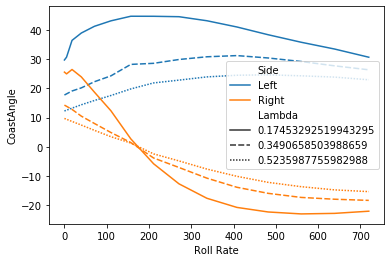

In [22]:
sns.lineplot(data=df[(df['Roll']==0) & (df['V']==15.0)],x='Roll Rate',y='CoastAngle',hue="Side",style='Lambda')


In [ ]:
y=np.deg2rad([10,40,20,0,-20,0])
%timeit -n 100 -r 100 nm.ExtForces(p.GetNumericTuple(y,0),y,0)

In [ ]:
np.round((1-np.cos(np.linspace(0,np.pi/2,15)))*720)